In [ ]:
# Importing library modules

from google.colab import files                               # To download files
import numpy as np                                           # For array operation
import matplotlib.pyplot as plt                              # For plotting
import glob                                                  # To dynamically load data
import cv2                                                   # Image related operation
from google.colab.patches import cv2
from tensorflow import keras
from tensorflow.keras import layers                        # For displaying image
from tensorflow.keras.preprocessing import image             # Image processing
from tensorflow.keras.applications.vgg16 import VGG16#MobileNetV2 # To import convolution base
from tensorflow.keras.applications.vgg16 import preprocess_input # To preprocess images according to the model
from keras.models import Model, Sequential                   # To import model skeleton
from keras.layers import Dense,Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D # To import layer and related methods, classes
import os                                                     # To find the path
import seaborn as sns                                         # For editing plots

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lavkesh1709","key":"65bac9f75b2cfc27eeba213309f1265f"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
#!kaggle datasets download -d vbookshelf/rice-leaf-diseases #0.5
# !kaggle datasets download -d dhamur/cotton-plant-disease  #0.36
!kaggle datasets download -d shuvoalok98/soybean-disease-dataset

100% 823M/823M [00:11<00:00, 136MB/s]
100% 823M/823M [00:11<00:00, 76.6MB/s]


In [ ]:
#!mkdir Dataset

In [ ]:
#!cp /content/drive/MyDrive/Kaggle/soybeanleafdataset.zip /content/Dataset/soybeanleafdataset.zip
#!unzip -q /content/Dataset/soybeanleafdataset.zip -d /content/Dataset
#!rm /content/Dataset/soybeanleafdataset.zip

In [ ]:
! unzip -q 'soybean-disease-dataset.zip'

In [ ]:
os.listdir()

['.config', 'soybean-disease-dataset.zip', 'sample_data']

In [ ]:
# Importing data from MyDrive

#print(os.listdir("/content/drive/MyDrive/FINAL(ORG)/"))

SIZE = 128
classes = 0
Timages = []
Tlabels = []
for directory_path in glob.glob("/content/soybean-disease-dataset.zip"):
    label = directory_path.split("/")[-1]
    num = 0
    if classes==2:
      break
    classes += 1
    print(label)
    print(directory_path)

    for img_path in glob.glob(os.path.join(directory_path,"*.*")):
      print(img_path)
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.resize(img, (SIZE, SIZE))
      #img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  #add image space converter
      img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

      Timages.append(img)
      Tlabels.append(label)
      #num+=1
      #if num>890:
       # break

Timages = np.array(Timages)
Tlabels = np.array(Tlabels)

soybean-disease-dataset.zip
/content/soybean-disease-dataset.zip


In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip('horizontal')
  ,layers.RandomRotation(0.2)
  ,layers.RandomContrast(0.2)
  ,layers.RandomZoom(0.5,0.2)
])


In [ ]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
rescale = layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Splitting data between training and testing sets

from sklearn.model_selection import train_test_split

# If integer encoding required
#x_train, x_val, y_train, y_val = train_test_split(Timages, Tlabels_encoded, test_size=0.33, random_state=42)

# If one hot encoding required
x_t, x_test, y_t, y_test = train_test_split(Timages, Tlabels, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=0.25, random_state=40)

ValueError: ignored

In [ ]:
#Encode labels from text to integers.

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

le.fit(y_val)
y_val = le.transform(y_val)

In [ ]:
# Perform one hot encoding

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
# Importing pre-trainned cnn 'MobileNetV2'

model = VGG16(input_shape = (128, 128, 3), weights='imagenet', include_top=False)
print(len(model.layers))

19


In [ ]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.layers.regularization.dropout import Dropout

#Add layers for feature extraction in deep learning
#inputs = keras.Input
#x = data_augmentation(inputs)
#x = preprocess_input(x)
x = model.output
feature_layer = GlobalAveragePooling2D()(x)
#feature_layer = Flatten()(x)
#feature_layer = BatchNormalization()(feature_layer)
feature_layer = Dropout(0.2)(feature_layer)
feature_layer = Dense(2, activation = 'softmax')(feature_layer)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs = model.input , outputs = feature_layer)

In [ ]:
# Freeznig layers and compiling the modelfor layers in (cnn_model.layers)[:-4]:
    print(layers)
    layers.trainable = False

#cnn_model.compile(optimizer='Adam',loss = 'binary_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
# Extract the features using the deep learning architecture

x_train_feature = cnn_model.predict(x_train) #This is out X input to Machine Classifier

23/23 [==============================] - 123s 5s/step


In [ ]:
# Immport machine learning classifier

#from sklearn.neighbors import KNeighborsClassifier
#MC_model = KNeighborsClassifier()
#from sklearn.ensemble import RandomForestClassifier
#MC_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
#from sklearn.ensemble import AdaBoostClassifier
#MC_model = AdaBoostClassifier(n_estimators=100)
#from sklearn.ensemble import GradientBoostingClassifier
#MC_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
from sklearn.linear_model import LogisticRegression
#MC_model = LogisticRegression(random_state=1)
from sklearn.multiclass import OneVsRestClassifier
MC_model = OneVsRestClassifier(LogisticRegression(random_state=1))

In [ ]:
# Inverse transform training labels

y_train = np.argmax(y_train,1)

In [ ]:
# Train the model on training data

MC_model.fit(x_train_feature, y_train)                # x - Image, y - Label

X_test_feature = cnn_model.predict(x_test)
prediction_MC_Unravel = MC_model.predict(X_test_feature)
prediction_MC = prediction_MC_Unravel
print(prediction_MC)
prediction_MC = le.inverse_transform(prediction_MC)
print(prediction_MC)

8/8 [==============================] - 41s 5s/step
[0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0
 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0
 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1
 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1
 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1]
['Army worm' 'Army worm' 'Target spot' 'Target spot' 'Target spot'
 'Target spot' 'Target spot' 'Target spot' 'Target spot' 'Army worm'
 'Army worm' 'Target spot' 'Army worm' 'Target spot' 'Army worm'
 'Target spot' 'Army worm' 'Army worm' 'Army worm' 'Army worm' 'Army worm'
 'Army worm' 'Target spot' 'Army worm' 'Army worm' 'Army worm' 'Army worm'
 'Target spot' 'Army worm' 'Target spot' 'Target spot' 'Army worm'
 'Army worm' 'Army worm' 'Army worm' 'Tar

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

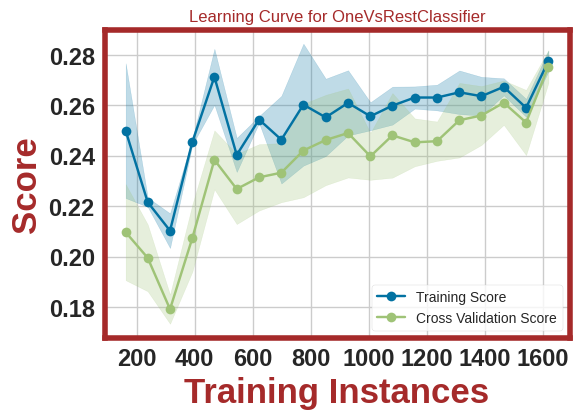

<Axes: title={'center': 'Learning Curve for OneVsRestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
# Draw learning curves with cross-validation

import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from yellowbrick.model_selection import LearningCurve

# Input the data
X = x_train_feature
y_train_decoded = y_train
y = y_train_decoded

# Create the learning curve visualizer
cv = 4
#cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.1, 1.0, 20)

# Instantiate the classification model and visualizer
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(4)
    ax.spines[axis].set_color('brown')

plt.xticks(fontsize=17,weight='bold')
plt.yticks(fontsize=17,weight='bold')

#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

visualizer = LearningCurve(MC_model, cv=cv, scoring='accuracy', train_sizes=sizes, ax=ax, kws = {'linewidths': [100,100]})
visualizer.fit(X, y)        # Fit the data to the visualizer

visualizer.ax.set_xlabel('Training instances',fontsize=25,color='brown',weight='bold')
visualizer.ax.set_ylabel('Score',fontsize=25,color='brown',weight='bold')
visualizer.ax.set_title('MobileNetV2+KN',fontsize=25,color='brown',weight='bold')
plt.xticks(fontsize=17,weight='bold')
plt.yticks(fontsize=17,weight='bold')
plt.legend(loc=(0.56,0.03), frameon=True, prop={'size':10,'weight':'bold'})

plt.savefig("MobileNetV2+KN.pdf", bbox_inches='tight')
files.download("MobileNetV2+KN.pdf")

visualizer.show()           # Finalize and render the figure

Accuracy =  0.5726141078838174
['Target spot' 'Army worm' 'Target spot' 'Target spot' 'Target spot'
 'Target spot' 'Target spot' 'Army worm' 'Army worm' 'Target spot'
 'Army worm' 'Target spot' 'Target spot' 'Target spot' 'Army worm'
 'Target spot' 'Target spot' 'Army worm' 'Target spot' 'Army worm'
 'Army worm' 'Target spot' 'Target spot' 'Army worm' 'Army worm'
 'Army worm' 'Target spot' 'Target spot' 'Target spot' 'Target spot'
 'Target spot' 'Target spot' 'Target spot' 'Target spot' 'Army worm'
 'Target spot' 'Army worm' 'Army worm' 'Target spot' 'Target spot'
 'Target spot' 'Target spot' 'Target spot' 'Army worm' 'Target spot'
 'Target spot' 'Target spot' 'Army worm' 'Target spot' 'Target spot'
 'Target spot' 'Target spot' 'Target spot' 'Target spot' 'Target spot'
 'Target spot' 'Army worm' 'Target spot' 'Army worm' 'Target spot'
 'Army worm' 'Target spot' 'Army worm' 'Target spot' 'Target spot'
 'Target spot' 'Target spot' 'Army worm' 'Target spot' 'Target spot'
 'Army worm' 'Tar

<Axes: >

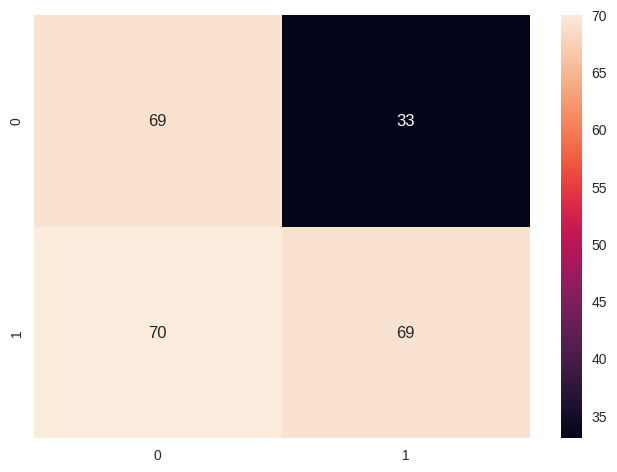

In [ ]:
#Print overall accuracy

from sklearn import metrics
from sklearn.metrics import confusion_matrix
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_MC))

print(y_test)
#print(le.inverse_transform(prediction_MC))



#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_test, prediction_MC)
#print(cm)
sns.heatmap(cm, annot=True)